In [7]:
pip install gradio

# Import thư viện

In [8]:
# 1. Import thư viện
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import joblib
import gradio as gr

# Làm sạch dữ liệu

In [9]:
# Hàm làm sạch văn bản
def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return None
    # Chuyển thành chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-z\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = ' '.join(text.split())
    return text if text else None

# 2. Đọc và tiền xử lý dữ liệu
# Đọc dữ liệu từ tệp CSV
df = pd.read_csv("/content/processed_dataset.csv_")

# Chỉ giữ lại các cột cần thiết
df = df[['feedback_text', 'sentiment', ]].copy()

# Làm sạch cột feedback_text
df['feedback_text'] = df['feedback_text'].apply(clean_text)

# Loại bỏ các hàng có feedback_text hoặc sentiment là NaN/None
df = df.dropna(subset=['feedback_text', 'sentiment'])

# Kiểm tra giá trị hợp lệ trong cột sentiment
valid_sentiments = ['Positive', 'Negative', 'Neutral']
df = df[df['sentiment'].isin(valid_sentiments)]

# Kiểm tra và loại bỏ các hàng có feedback_text rỗng
df = df[df['feedback_text'].str.strip().str.len() > 0]

# Lưu dữ liệu đã xử lý
df.to_csv('cleaned_dataset.csv', index=False)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Xây dựng mô hình

In [11]:
# 3. Chia dữ liệu (giả định bạn đã có biến df chứa feedback_text và sentiment)
X_train, X_test, y_train, y_test = train_test_split(
     df['feedback_text'],
     df['sentiment'],
     test_size=0.2,
     random_state=42,
     stratify=df['sentiment']
)

# 4. Xây dựng lớp mô hình
class AspectSentimentAnalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        self.model = MultinomialNB()

    def train(self, X, y):
        X_vec = self.vectorizer.fit_transform(X)
        self.model.fit(X_vec, y)

    def predict(self, texts):
        X_vec = self.vectorizer.transform(texts)
        return self.model.predict(X_vec)

# 5. Huấn luyện và lưu mô hình
analyzer = AspectSentimentAnalyzer()
analyzer.train(X_train, y_train)
joblib.dump(analyzer, 'aspect_sentiment_model_english.pkl')

# 6. Từ khóa xác định chủ đề (Aspect)
ASPECT_KEYWORDS = {
    'App Experience': ['app', 'application', 'interface', 'experience', 'mobile', 'login'],
    'Customer Service': ['support', 'customer service', 'response', 'care', 'help'],
    'Delivery': ['delivery', 'shipping', 'ship', 'late', 'slow', 'on time'],
    'Product Quality': ['product', 'quality', 'damaged', 'defective', 'good', 'poor']
}

def detect_aspect(text):
    text_lower = text.lower()
    for aspect, keywords in ASPECT_KEYWORDS.items():
        if any(kw in text_lower for kw in keywords):
            return aspect
    return "Undefined"

# 7. Automated Response Templates
RESPONSE_TEMPLATES = {
    'App Experience': {
        'Positive': "Thank you for your positive feedback about our app!",
        'Negative': "We're sorry to hear you had issues with the app experience. We'll work on improving it.",
        'Neutral': "Thank you for sharing your experience using the app."
    },
    'Customer Service': {
        'Positive': "Glad to hear you're satisfied with our customer service!",
        'Negative': "We're very sorry for the poor service experience. Thank you for your feedback.",
        'Neutral': "We will take your feedback about our customer service into consideration."
    },
    'Delivery': {
        'Positive': "Happy to hear you're satisfied with our delivery service!",
        'Negative': "We apologize for the delivery issue. Please provide more details.",
        'Neutral': "Thank you for your feedback regarding the delivery."
    },
    'Product Quality': {
        'Positive': "Great to hear you're happy with the product!",
        'Negative': "Sorry to hear the product did not meet expectations. We will work to improve.",
        'Neutral': "Thank you for your comments about the product."
    },
    'Undefined': {
        'Positive': "Thank you for your positive feedback!",
        'Negative': "We're sorry you had a negative experience. Please provide more details.",
        'Neutral': "Thank you for sharing your opinion."
    }
}

# 8. Analysis and Auto-response
loaded_model = joblib.load('aspect_sentiment_model_english.pkl')

def analyze_and_respond(text):
    text_cleaned = clean_text(text)
    if not text_cleaned:
        return "Invalid input. Please provide meaningful feedback."

    aspect = detect_aspect(text_cleaned)
    sentiment = loaded_model.predict([text_cleaned])[0]
    response = RESPONSE_TEMPLATES.get(aspect, {}).get(sentiment, "Thank you for your feedback. We will use it to improve.")

    return f""" Category feedback: {aspect}
 Sentiment: {sentiment}
 Auto-Response:
{response}"""



# Đánh giá mô hình

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.93      0.97       328
     Neutral       1.00      1.00      1.00       348
    Positive       0.94      1.00      0.97       324

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
[[306   0  22]
 [  0 348   0]
 [  0   0 324]]
Accuracy Score: 0.978


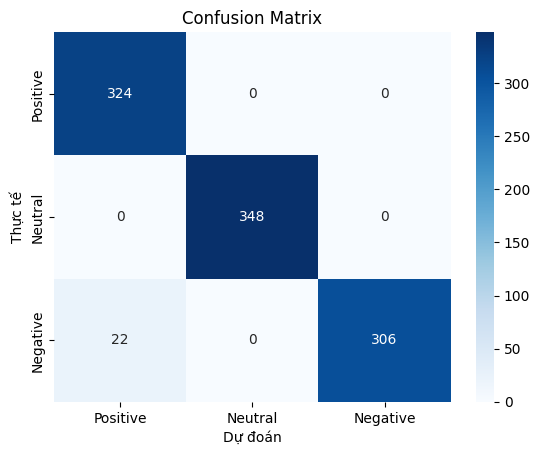

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Vector hóa dữ liệu kiểm tra
X_test_vec = analyzer.vectorizer.transform(X_test)
# Dự đoán
y_pred = analyzer.model.predict(X_test_vec)
# Báo cáo tổng hợp độ chính xác, recall, f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Ma trận nhầm lẫn
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# Độ chính xác tổng thể
print("Accuracy Score:", accuracy_score(y_test, y_pred))
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=["Positive", "Neutral", "Negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Neutral", "Negative"], yticklabels=["Positive", "Neutral", "Negative"])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix")
plt.show()


# Triển khai mô hình

In [13]:
# 9. Gradio Interface
interface = gr.Interface(
    fn=analyze_and_respond,
    inputs="text",
    outputs="text",
    title="ASPECT & SENTIMENT ANALYSIS SYSTEM OF GROUP 5 - CAPSTONE 1",
    description="Enter feedback (in English) to analyze the corresponding aspect and sentiment."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4a6d8bb86ea7797c0e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
